In [2]:
from pickle import load
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from chainconsumer import ChainConsumer
from multiprocessing import Pool

import src.forward_model as FM
import src.beam_functions as BF
import src.inference as INF
import src.map_making as MM
import src.observing as OBS
import src.sky_models as SM
from anstey.generate import T_CMB
from src.spherical_harmonics import RealSphericalHarmonics, calc_spherical_harmonic_matrix
from src.nregions_models import pix_forward_model_pl, genopt_pix_forward_model_pl
from src.blockmat import BlockMatrix, BlockVector
RS = RealSphericalHarmonics()
from nregions_inference import nuarr
import nregions_inference as NRI
from scipy.optimize import curve_fit
from functools import partial
import alm_polynomial_inference as api
from multifrequency_ml_modelling import _plot_results, _plot_results_mcmc

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler

def param_estimator(chain, stats="mean"):
    if stats=="mean":
        theta_est = np.mean(chain, axis=0)
    elif stats=="max":
        c = ChainConsumer()
        c.add_chain(chain, statistics=stats)
        analysis_dict = c.analysis.get_summary(squeeze=True)
        theta_est = np.array([val[1] for val in analysis_dict.values()])
    return theta_est

saveloc = "Alm_polyn/"

def fg_polymod(nuarr, *theta_fg):
    Afg, alpha = theta_fg[:2]
    zetas      = theta_fg[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    fg_a00_terms = (Afg*1e3)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return fg_a00_terms + np.sqrt(4*np.pi)*T_CMB

def cm21_mod(nuarr, *theta_21):
    A21, nu0, dnu = theta_21
    cm21_a00_terms = np.sqrt(4*np.pi) * A21 * np.exp(-.5*((nuarr-nu0)/dnu)**2)
    return cm21_a00_terms

def fg_cm21_polymod(nuarr, *theta):
    theta_fg = theta[:-3]
    theta_21 = theta[-3:]
    return fg_polymod(nuarr, *theta_fg) + cm21_mod(nuarr, *theta_21)

In [4]:
# Generate the data.
nside = 32
lmod  = 1
lmax  = 32
chrom = 1.6e-2
times = np.linspace(0, 24, 12, endpoint=False)
noise = 0.01
lats  = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])#[-26, 26]
Nlmax   = RS.get_size(lmax)
Nlmod   = RS.get_size(lmod)
cm21_mon_pars = [-0.2, 80.0, 5.0]
basemap_err = 5
delta = SM.basemap_err_to_delta(percent_err=basemap_err)

# Generate foreground and 21-cm signal alm
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err), err_type='idx', seed=100, meancorr=False)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_mon_pars)
fid_alm  = fg_alm + cm21_alm

# Generate observation matrix for the modelling and for the observations.
if chrom is not None:
    if not isinstance(chrom, bool):
        chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    else:
        chromfunc = BF.fwhm_func_tauscher
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(nuarr, nside, lmax, lats=lats, times=times, return_mat=False, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc, Ntau=1)
elif chrom is None:
    narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False, Ntau=1)
    mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [6]:
mat_A

(1, 1089) x 51 BlockMatrix

In [18]:
def test_models():
    original_model = FM.generate_binwise_cm21_forward_model(nuarr, mat_A, Npoly)
    optimized_model = FM.genopt_binwise_cm21_forward_model(nuarr, mat_A, Npoly)

    theta = np.random.rand(Npoly * mat_A.block_shape[0] + 3)
    original_output = original_model(theta)
    optimized_output = optimized_model(theta)

    # Check if the outputs are the same to machine accuracy
    assert np.allclose(original_output, optimized_output, atol=1e-10), "Outputs are not the same to machine accuracy"

    print("Test passed: Both models return the same output to machine accuracy.")
test_models()

[0.00915087 0.33005036 0.1092477  0.35383269 0.78637943 0.15152325
 0.50911333]
Test passed: Both models return the same output to machine accuracy.


In [2]:
7*51*12

4284

In [3]:
# Generate the data.
nside = 32
lmod  = 1
lmax  = 32
chrom = 1.6e-2
times = np.linspace(0, 24, 12, endpoint=False)
noise = 0.01
lats  = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])#[-26, 26]
Nlmax   = RS.get_size(lmax)
Nlmod   = RS.get_size(lmod)
cm21_mon_pars = [-0.2, 80.0, 5.0]
basemap_err = 5
delta = SM.basemap_err_to_delta(percent_err=basemap_err)

# Generate foreground and 21-cm signal alm
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err), err_type='idx', seed=100, meancorr=False)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_mon_pars)
fid_alm  = fg_alm + cm21_alm

# Generate observation matrix for the modelling and for the observations.
if chrom is not None:
    if not isinstance(chrom, bool):
        chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    else:
        chromfunc = BF.fwhm_func_tauscher
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(nuarr, nside, lmax, lats=lats, times=times, return_mat=False, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc)
elif chrom is None:
    narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
    mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))

# Perform fiducial observations
d = mat_A @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=100, seed=456)#t_int=100, seed=456)#
err = np.sqrt(noise_covar.diag)

# Calculate the missing-modes observation matrix.
mat_A_mod = mat_A[:,:Nlmod]
mat_A_unmod = mat_A[:,Nlmod:]

# Generate a missing-modes correction analytically.
alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, basemap_err)
data_corr = mat_A_unmod @ alm_mean
covar_corr = mat_A_unmod @ alm_cov @ mat_A_unmod.T

# Reconstruct the max likelihood estimate of the alm
mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar+covar_corr, cov=True, cond=True)
alm_error = np.sqrt(cov.diag)
rec_alm = mat_W @ (dnoisy - data_corr)

# Extract the monopole component of the reconstructed alm.
rec_a00 = np.array(rec_alm.vector[::Nlmod])
a00_error = np.array(alm_error[::Nlmod])

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<5>
1/condition #: 0.00037625340873525306


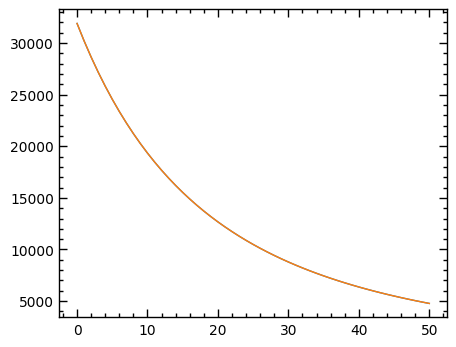

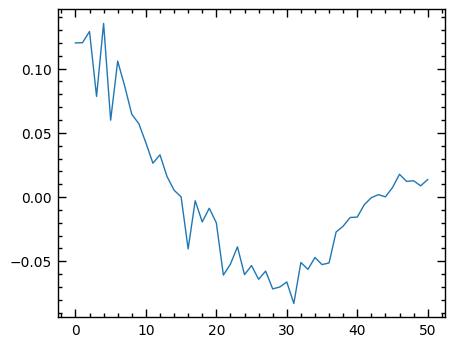

In [4]:
fid_alm_bv = BlockVector(fid_alm, nblock=len(nuarr))
plt.plot(rec_a00)
plt.plot(fid_alm_bv[0])
plt.show()
plt.plot(fid_alm_bv[0]-rec_a00)
plt.show()

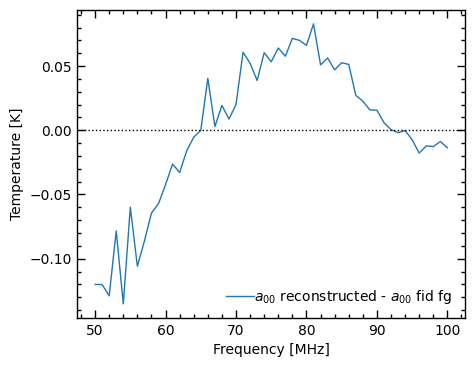

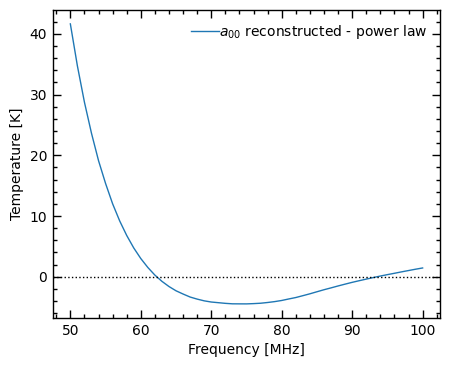

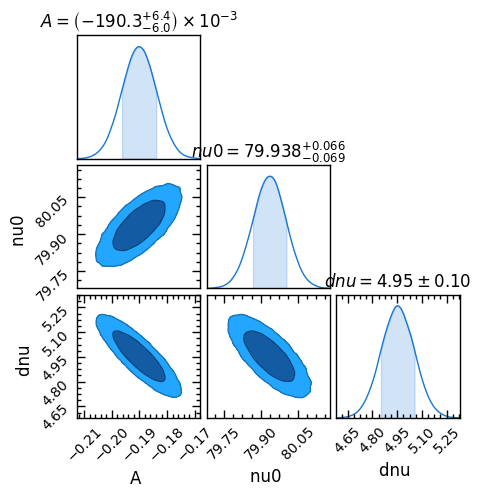

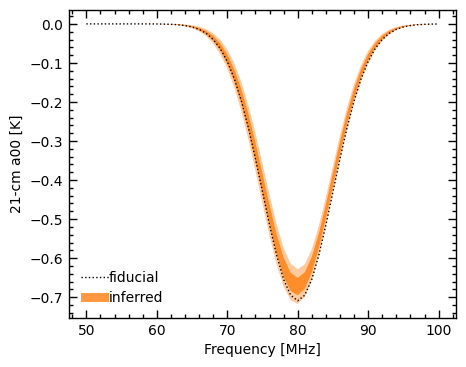

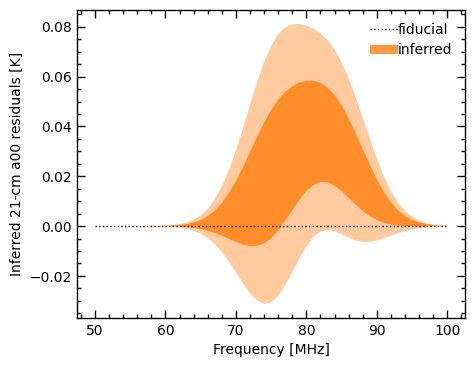

In [5]:
# Fit the reconstructed a00 component with a polynomial and 21-cm gaussian
Npoly=6
fg_mon_p0 = [15, 2.5]
fg_mon_p0 += [.001]*(Npoly-2)
cm21_mon_p0 = [-0.2, 80, 5]

bounds = [[1, 25], [1.5, 3.5]]
bounds += [[-2, 2.1]]*(Npoly-2)
bounds += [[-0.45, -0.011], [71, 89], [2, 7]]
bounds = [list(x) for x in zip(*bounds)]

res = curve_fit(f=fg_cm21_polymod, xdata=nuarr, ydata=rec_a00, sigma=a00_error, p0=fg_mon_p0+cm21_mon_p0, method="dogbox", bounds=bounds)

_plot_results(nuarr, Nlmax, Nlmod, rec_alm.vector, alm_error, fid_alm, cm21_alm, res)

In [6]:
res[0]

array([ 1.93202741e+01,  2.74376735e+00,  9.64697770e-03, -2.04312222e-04,
       -1.05460914e-03,  1.74958109e-03, -1.90114028e-01,  7.99354953e+01,
        4.95374012e+00])

In [7]:
steps=10000
burn_in=3000
def mod(theta):
    return fg_cm21_polymod(nuarr, *theta)

# create a small ball around the MLE to initialize each walker
nwalkers, fg_dim = 64, Npoly+3
ndim = fg_dim
pos = res[0]*(1 + 1e-4*np.random.randn(nwalkers, ndim))
priors = [[1, 25], [1.5, 3.5]]
priors += [[-2, 2.1]]*(Npoly-2)
priors += [[-0.5, -0.01], [70, 90], [1, 8]]
priors = np.array(priors)
# run emcee without priors
sampler = EnsembleSampler(nwalkers, ndim, INF.log_posterior, 
                    args=(rec_a00, a00_error, mod, priors))
_=sampler.run_mcmc(pos, nsteps=steps, progress=True, skip_initial_state_check=True)
chain_mcmc = sampler.get_chain(flat=True, discard=burn_in)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:29<00:00, 111.47it/s]


In [8]:
a00_error

array([0.17327116, 0.16235137, 0.15181567, 0.14167228, 0.13192729,
       0.12258498, 0.11364845, 0.10512109, 0.09700975, 0.08933128,
       0.08212312, 0.07545304, 0.06941084, 0.06408617, 0.05954859,
       0.05572143, 0.05240885, 0.04947827, 0.04689552, 0.04467797,
       0.04282993, 0.04132951, 0.04014592, 0.03923928, 0.03852455,
       0.03792431, 0.03738349, 0.0368234 , 0.03616766, 0.03538409,
       0.03441842, 0.03322887, 0.0318137 , 0.03016021, 0.0282964 ,
       0.02626702, 0.0241054 , 0.02186275, 0.01959914, 0.01738228,
       0.01528394, 0.01334767, 0.01153994, 0.00984875, 0.00842972,
       0.00745152, 0.00698894, 0.00699491, 0.00734374, 0.00782302,
       0.00825013])

<ErrorbarContainer object of 3 artists>

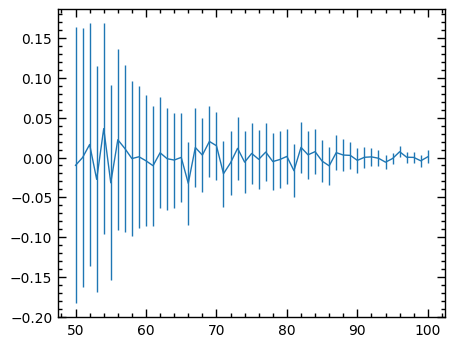

In [9]:
plt.errorbar(nuarr,mod(res[0])-rec_a00, a00_error)

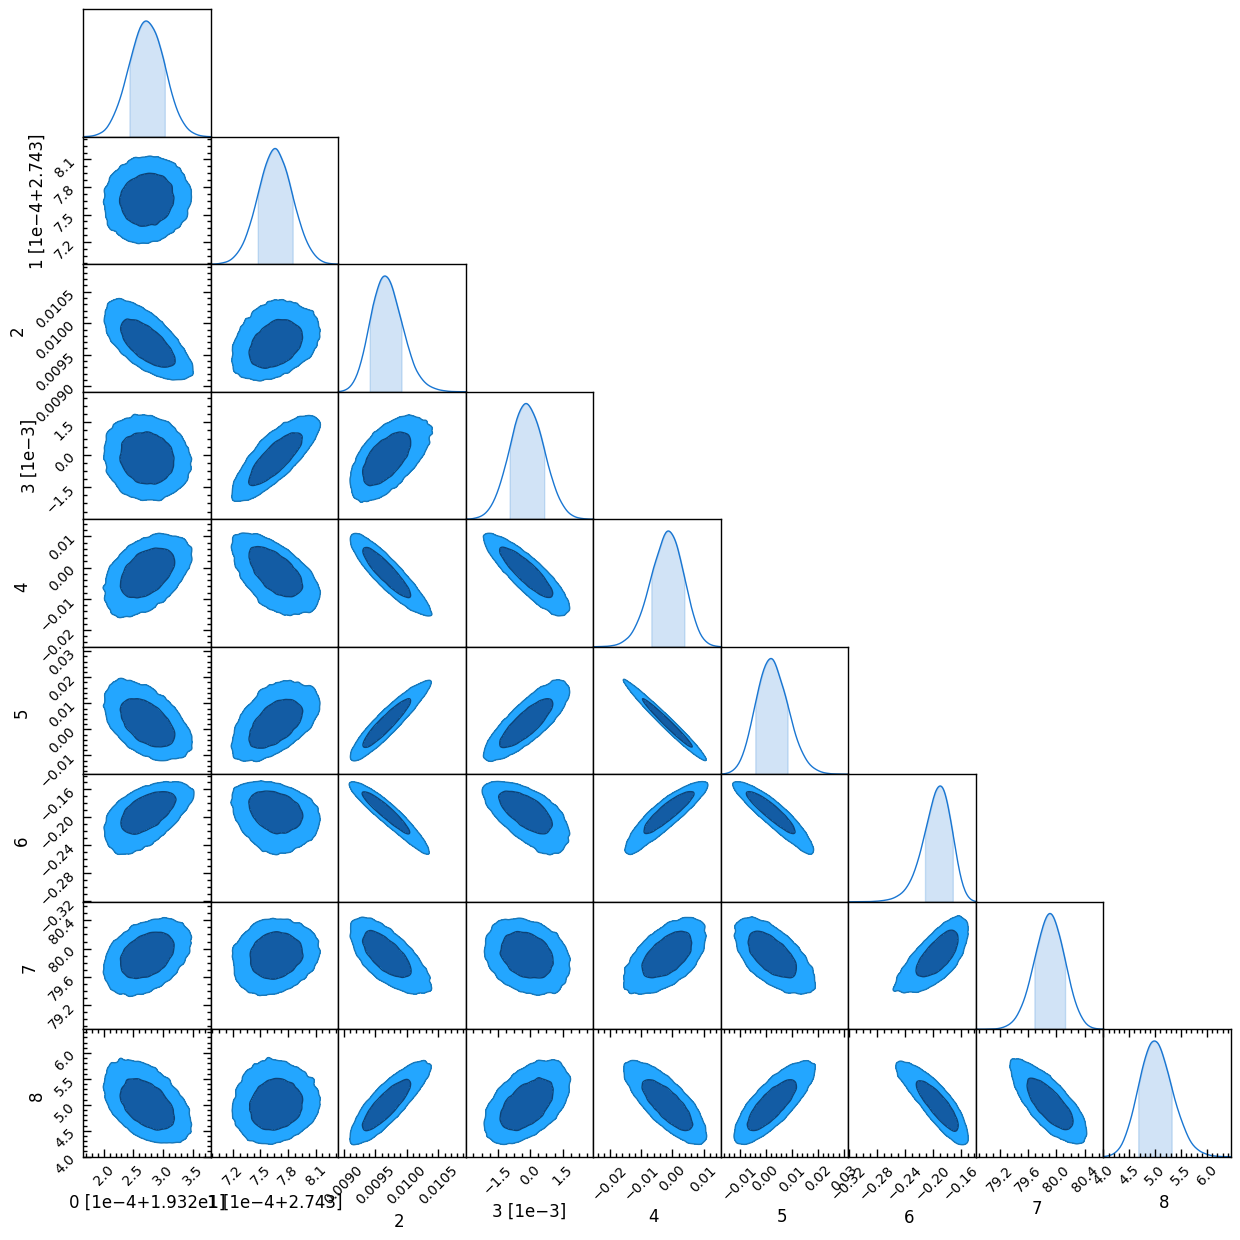

In [10]:
c = ChainConsumer()
c.add_chain(chain_mcmc)
f=c.plotter.plot()
plt.show()

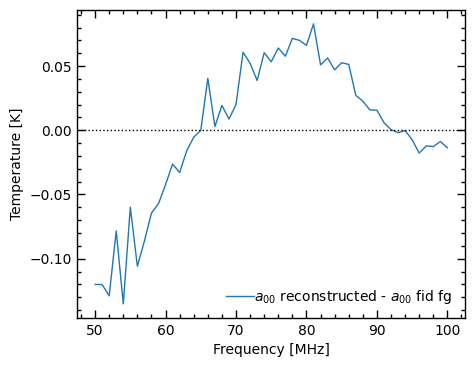

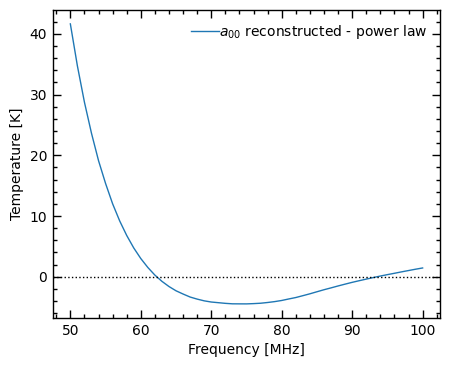

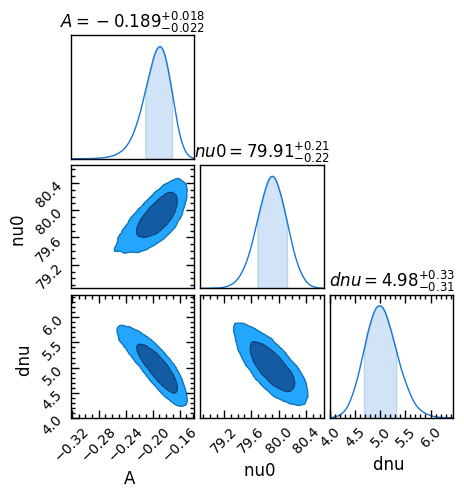

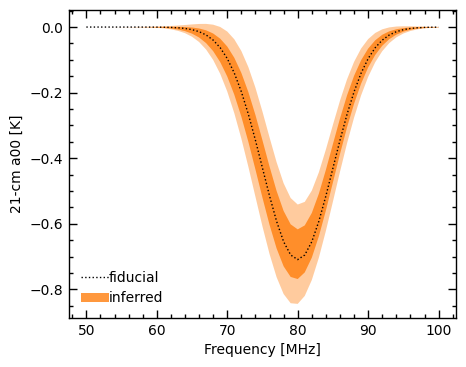

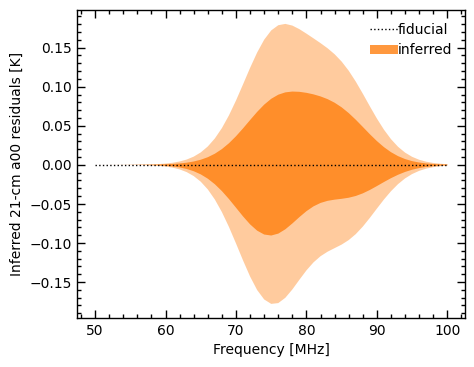

In [11]:
_plot_results_mcmc(nuarr, Nlmax, Nlmod, rec_alm.vector, alm_error, fid_alm, cm21_alm, chain_mcmc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:19<00:00, 125.12it/s]


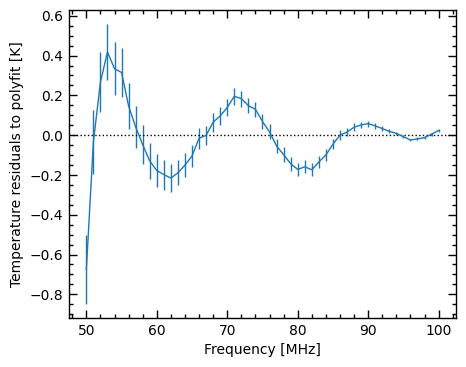

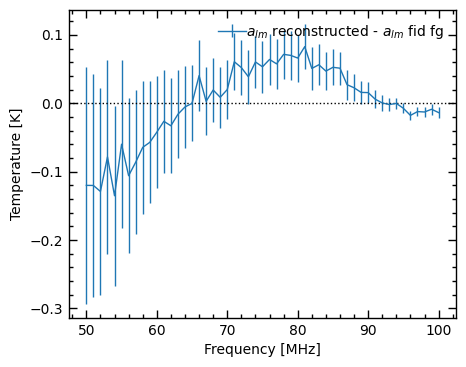

In [12]:
# Extract the multipole components of the reconstructed alm.
rec_a1m1 = np.array(rec_alm.vector[1::Nlmod])
a1m1_error = np.array(alm_error[1::Nlmod])
rec_a10 = np.array(rec_alm.vector[2::Nlmod])
a10_error = np.array(alm_error[2::Nlmod])
rec_a1p1 = np.array(rec_alm.vector[3::Nlmod])
a1p1_error = np.array(alm_error[3::Nlmod])


def polyfit_alm(alm, alm_err, fid_alm):
    # Fit the reconstructed alm component with a polynomial.
    Npoly=6
    fg_mon_p0 = [5, 2.5]
    fg_mon_p0 += [.001]*(Npoly-2)
    
    bounds = [[-10, 25], [1.5, 3.5]]
    bounds += [[-2, 2.1]]*(Npoly-2)
    bounds = [list(x) for x in zip(*bounds)]
    
    res = INF.curve_fit_emcee(f=fg_polymod, xdata=nuarr, ydata=alm, sigma=alm_err, p0=fg_mon_p0, bounds=bounds)

    plt.errorbar(nuarr, alm-fg_polymod(nuarr, *res[0]), alm_err)
    plt.axhline(y=0, linestyle=":", color='k')
    plt.ylabel("Temperature residuals to polyfit [K]")
    plt.xlabel("Frequency [MHz]")
    plt.show()
    
    # Plot the reconstructed alm mode minus the fiducial alm mode.
    plt.errorbar(nuarr, alm-fid_alm, alm_err, label='$a_{lm}$ reconstructed - $a_{lm}$ fid fg')
    plt.axhline(y=0, linestyle=":", color='k')
    plt.legend()
    plt.ylabel("Temperature [K]")
    plt.xlabel("Frequency [MHz]")
    plt.show()

polyfit_alm(rec_a00, a00_error, fid_alm_bv[0])

In [13]:
Npoly=6
# Fit the alms recovered using 6-order polynomials.
alm_error_bv = BlockVector(alm_error, nblock=len(nuarr))
res_list = []
for n in range(Nlmod):
    Npoly=Npoly
    fg_mon_p0 = [5, 2.5]
    fg_mon_p0 += [.001]*(Npoly-2)
    
    bounds = [[-10, 25], [1.5, 3.5]]
    bounds += [[-2, 2.1]]*(Npoly-2)
    bounds = [list(x) for x in zip(*bounds)]
    res = INF.curve_fit_emcee(f=fg_polymod, xdata=nuarr, ydata=rec_alm[n], sigma=alm_error_bv[n], p0=fg_mon_p0, bounds=bounds)
    res_list.append(res[0])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:21<00:00, 122.46it/s]


In [14]:
# Generate a missing-modes correction analytically.
mat_A_unmod = BlockMatrix(mat_A.block[:,:,Nlmod:])
alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, basemap_err)
covar_corr = mat_A_unmod @ alm_cov @ mat_A_unmod.T
alms_for_corr = np.reshape(alm_mean, (Nlmax-Nlmod, len(nuarr)))
total_inv_cov = (noise_covar + covar_corr).inv
total_inv_cov_np = total_inv_cov.matrix

# Set up the alm forward model
mod_fg = FM.genopt_alm_plfid_forward_model(nuarr, observation_mat=mat_A, fid_alm=alms_for_corr, Npoly=Npoly, lmod=lmod, lmax=lmax)
priors = [[-10, 25], [1.5, 3.5]]
priors += [[-100, 100.1]]*(Npoly-2)
priors = np.array(priors*Nlmod)

Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<5>


In [15]:
ndim

9

In [18]:
# Run MCMC inference

nwalkers, fg_dim = 64, Npoly*Nlmod
ndim = fg_dim
pos = np.array(res_list).flatten()*(1 + 1e-4*np.random.randn(nwalkers, ndim))
sampler = EnsembleSampler(nwalkers, ndim, INF.log_posterior_vectors, 
                    args=(dnoisy.vector, total_inv_cov_np, mod_fg, priors))#, pool=pool)
_=sampler.run_mcmc(pos, nsteps=steps, progress=True)

  0%|                                                                                                                                                                  | 2/10000 [00:12<17:11:29,  6.19s/it]Traceback (most recent call last):
  File "/Users/yordani/Documents/wonky_compass/sky-observer2/venvskob/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/src/inference.py", line 79, in log_posterior_vectors
    lp += log_likelihood_vectors(theta, y, invcov, model)
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/src/inference.py", line 26, in log_likelihood_vectors
    y_model = model(theta)
KeyboardInterrupt
  0%|                                                                                                                                                                  | 2/10000 [00:14<20:49:39,  7.50s/it]

emcee: Exception while calling your likelihood function:
  params: [ 1.93206419e+01  2.74370861e+00  7.56874846e-03 -7.04875074e-03
  4.85742878e-02 -5.61642565e-02  1.62817835e+00  2.56992371e+00
 -4.44886430e-02 -1.44804750e-02  5.28923760e-03 -2.99100069e-02
  3.91035299e-01  2.71682635e+00 -7.85004403e-02 -5.13324399e-02
 -1.65472299e-01  3.71554669e-02 -6.17260203e+00  2.55984951e+00
 -1.30256188e-04  9.25782957e-03 -1.09575084e-02  1.41606192e-02]
  args: (array([7974.10423031, 7601.46679892, 7599.2664861 , ..., 1274.19131893,
       1317.28782912, 1327.91763178]), array([[   24.09838869,   -26.16833256,    18.53589785, ...,
            0.        ,     0.        ,     0.        ],
       [  -26.16833256,    34.93583539,   -31.30029569, ...,
            0.        ,     0.        ,     0.        ],
       [   18.53589785,   -31.30029569,    40.51284492, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , 

KeyboardInterrupt: 

In [20]:
import time

In [21]:
start=time.time()
i=0
while i < 10:
    mod_fg(np.array(res_list).flatten())
    i += 1
print(time.time()-start,"sec")

0.9389698505401611 sec


In [22]:
start=time.time()
i=0
while i < 10:
    INF.log_posterior_vectors(np.array(res_list).flatten(), dnoisy.vector, total_inv_cov_np, mod_fg, priors)
    i += 1
print(time.time()-start,"sec")

0.9914147853851318 sec


In [36]:
dnoisy

(84,) x 51 BlockVector